<a href="https://colab.research.google.com/github/xTavi/BlackBoxAttack/blob/master/BlackBoxAttack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from __future__ import print_function
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.core.debugger import set_trace
from matplotlib import pyplot
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/gdrive')
import torch.onnx
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
# import utils
import math
import random
import pdb

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [23]:
# class containing parameters for CNN optimizer  
kwargs={}
class Args():
  def __init__(self):
      self.batch_size = 64
      self.test_batch_size = 64
      self.epochs = 10#10
      self.lr = 0.01
      self.momentum = 0.9
      self.seed = 1
      self.log_interval = int(10000 / self.batch_size)
      self.cuda = False

args = Args()
use_cuda = torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [24]:
# code to download MNIST datasets for first method
# loaders for train and test data, respectively
# the data will be in pytorch tensor format

train_loader = torch.utils.data.DataLoader(
    dset.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=args.batch_size, shuffle=True,drop_last=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    dset.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=args.test_batch_size, shuffle=True,drop_last=True, **kwargs)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [25]:
# change folder to keep track later on
# note - don't change before downloading the MINST data
os.chdir("/content/gdrive/My Drive/")
# data is saved in the main directory in google drive

In [26]:
# arhitecture for CNN
# will use those same parameters in the following cells
# serves as a starting point for fully connected CNN
number_of_filters_1 = 20
number_of_filters_2 = 50
nn1 = 500
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, number_of_filters_1, 5, 1)
        self.conv2 = nn.Conv2d(number_of_filters_1, number_of_filters_2, 5, 1)
        self.fc1 = nn.Linear(4*4*number_of_filters_2, nn1)
        # 10 classes, one for each digit
        self.fc2 = nn.Linear(nn1, 10)

    def forward(self, x):
        # activation functions
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*number_of_filters_2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
# define a function for training and testing, respectively
# similar to what we have done in the laboratory
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    # use batches
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        # print loss at every step of the way
        if batch_idx % args.log_interval == 0:
            print('Train data performance for epoch {}:  for {:.0f}% of the data we have loss: {:.6f}'.format(epoch, 100. * batch_idx / len(train_loader), loss.item()))
            
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    # for accuracy we will
    # keep track of how many correct items classified as a percentage of total
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item() 
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True) 
            # increment correctly classified items
            correct += pred.eq(target.view_as(pred)).sum().item()

    # divide by the number of examples to get average loss
    test_loss /= len(test_loader.dataset)
    # print average loss and accuracy on test data
    print('Computing accuracy on the test data: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

In [27]:
# create and train, test our CNN
model = CNN().to(device)

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(args, model, device, test_loader)

# we save the model to save parameters for later
torch.save(model.state_dict(),"conv_net.pt")

TypeError: ignored

Epsilons: List of epsilon values to use for the run. It is important to keep 0 in the list because it represents the model performance on the original test set. Also, intuitively we would expect the larger the epsilon, the more noticeable the perturbations but the more effective the attack in terms of degrading model accuracy. Since the data range here is [0,1], no epsilon value should exceed 1.

In [28]:
pretrained_model = "conv_net.pt"
use_cuda=True

In [29]:
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = CNN().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. 
model.eval()

CUDA Available:  False


CNN(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

# Let's do a black box SimBa attack

In [30]:
#Here we add the element we need 

adv = []
number_of_correct = 0
accuracies = []

In [31]:
def get_probs(model, x, y):
    output = model(x)
    probs = torch.nn.Softmax(dim=1)(output)[:, y]
    return torch.diag(probs.data)

# 20-line implementation of (untargeted) SimBA for single image input
def simba_single(model, x, y, num_iters=10000, epsilon=0.2):
    n_dims = x.view(1, -1).size(1)
    perm = torch.randperm(n_dims)
    last_prob = get_probs(model, x, y)
    for i in range(num_iters):
        diff = torch.zeros(n_dims)
        diff[perm[i]] = epsilon
        left_prob = get_probs(model, (x - diff.view(x.size())).clamp(0, 1), y)
        if left_prob < last_prob:
            x = (x - diff.view(x.size())).clamp(0, 1)
            last_prob = left_prob
        else:
            right_prob = get_probs(model, (x + diff.view(x.size())).clamp(0, 1), y)
            if right_prob < last_prob:
                x = (x + diff.view(x.size())).clamp(0, 1)
                last_prob = right_prob
        # Here I want that if the model missclasify it to stop the procedure
        prediction = model(x).argmax()
        # We save the adversarial examples as a touple formed by initial label, predicted label, adversarial_image and epsioln
        if prediction != y:
          adv.append((y.item(), prediction.item(), x, epsilon))
          break

    return x

We can attack now

In [32]:
# This function should return the accouracy for a given epsilon
def adversarial_attack(epsilon):
  for batch_idx, (data, target) in enumerate(test_loader):
          data, target = data.to(device), target.to(device)
          initial_predictions = model(data)
          initial_predictions = initial_predictions.argmax(dim=1, keepdim=True)
          initial_correctness = 0
          initial_correctness += initial_predictions.eq(target.view_as(initial_predictions)).sum().item()
          
          print(f'Initial accuracy for batch {batch_idx}/{ math.floor(len(test_loader.dataset)/len(data)) } was ', 100.  * initial_correctness / len(target), "%")

          bigger_result = torch.zeros(1,1,28,28)
          for x, y in zip(data,target):
            x = x.unsqueeze(dim=0)
            result = simba_single(model, x, y, 784, epsilon)
            result.unsqueeze(dim=0)
            bigger_result = torch.cat((bigger_result, result))

          final_result = bigger_result[1:]
          final_predictions = model(final_result).argmax(dim=1, keepdim=True)
          final_corectness = 0
          final_corectness += final_predictions.eq(target.view_as(final_predictions)).sum().item()
          # number_of_correct += final_corectness
          accouracy  = 100.  * final_corectness / len(target)
          print(f'Final accuracy for batch {batch_idx}/{math.floor(len(test_loader.dataset)/len(data))  } was ', accouracy ,"%")
          
          return accouracy


In [33]:
epsilons = [0, .05, .1, .15, .2]

for eps in epsilons:
    acc = adversarial_attack(eps)
    accuracies.append(acc)

Initial accuracy for batch 0/156 was  98.4375 %
Final accuracy for batch 0/156 was  98.4375 %
Initial accuracy for batch 0/156 was  100.0 %
Final accuracy for batch 0/156 was  96.875 %
Initial accuracy for batch 0/156 was  98.4375 %
Final accuracy for batch 0/156 was  70.3125 %
Initial accuracy for batch 0/156 was  98.4375 %
Final accuracy for batch 0/156 was  56.25 %
Initial accuracy for batch 0/156 was  100.0 %
Final accuracy for batch 0/156 was  37.5 %


In [34]:
tensor_accuracies = torch.tensor(accuracies)/100

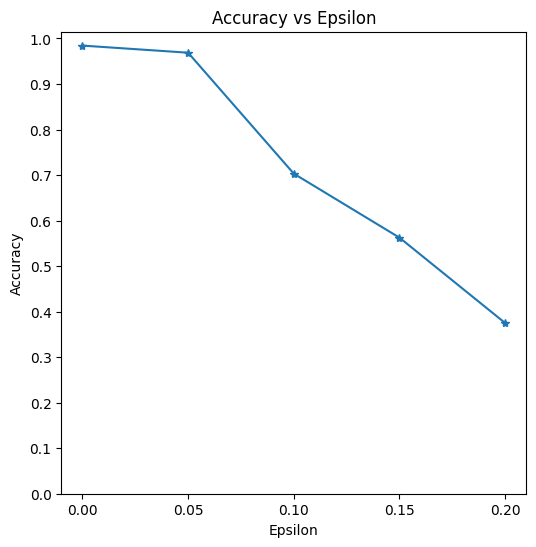

In [35]:
plt.figure(figsize=(6,6))
# print(accuracies)
plt.plot(epsilons, tensor_accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .25, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [36]:
# We want to create an len(epsilons)*5 matrix for printing

matrix = []

In [37]:
for epsilon in epsilons:
  i = 0;
  for item_adv in adv:
    if item_adv[3] == epsilon and i<5:
      matrix.append(item_adv)
      i+=1
      print(f"am gaist unu pentru eps {epsilon}")

print(len(matrix))


am gaist unu pentru eps 0
am gaist unu pentru eps 0.05
am gaist unu pentru eps 0.05
am gaist unu pentru eps 0.1
am gaist unu pentru eps 0.1
am gaist unu pentru eps 0.1
am gaist unu pentru eps 0.1
am gaist unu pentru eps 0.1
am gaist unu pentru eps 0.15
am gaist unu pentru eps 0.15
am gaist unu pentru eps 0.15
am gaist unu pentru eps 0.15
am gaist unu pentru eps 0.15
am gaist unu pentru eps 0.2
am gaist unu pentru eps 0.2
am gaist unu pentru eps 0.2
am gaist unu pentru eps 0.2
am gaist unu pentru eps 0.2
18


In [ ]:
matrix[0]

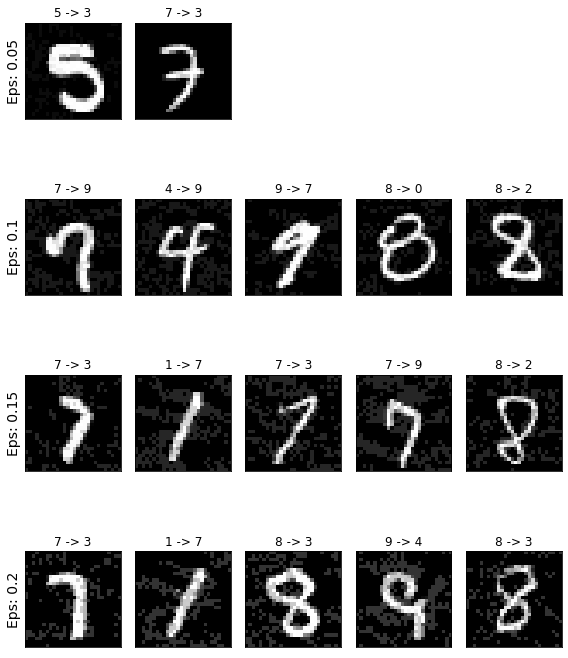

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
poz =0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)-1):
    for special in range(2):
      if cnt > 3:
        continue
      cnt += 1
      plt.subplot(4, 5, cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if cnt == 1:
        plt.ylabel("Eps: {}".format(epsilons[i+1]), fontsize=14)
      orig,adv,ex,_ = matrix[poz]
      poz += 1
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex[0][0], cmap="gray")
      if cnt == 2:
        cnt += 3
    for j in range(5):
        if cnt < 5 or cnt >= 20:
          continue
        cnt += 1
        plt.subplot(4, 5, cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j%5 == 0:
            plt.ylabel("Eps: {}".format(epsilons[i+2]), fontsize=14)
        orig,adv,ex,_ = matrix[poz]
        poz += 1
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex[0][0], cmap="gray")
plt.tight_layout()
plt.show() 

# Here we will add the second cnn called LeNet5 - 1990

In [85]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [74]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 10

IMG_SIZE = 32
N_CLASSES = 10

In [75]:
# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [76]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [77]:
def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [78]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:
            #print(X.size())
            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [79]:
def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [80]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [86]:
# define transforms
transforms1 = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms1,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms1)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

In [87]:
trans = transforms.ToPILImage()

In [ ]:
trans1 = transforms.ToTensor()
plt.imshow(trans(trans1(img)))

In [90]:
trans(b)

In [95]:
type(trans(b))

c = transforms1(trans(b))


In [96]:
c.size()

torch.Size([1, 32, 32])

In [57]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [58]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [ ]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

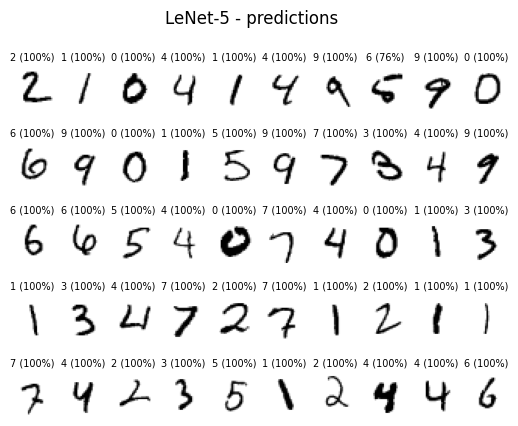

In [15]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');

In [103]:
# we save the model to save parameters for later
torch.save(model.state_dict(),"LeNet5.pt")

use_cuda = True 

In [104]:
pretrained_model = "LeNet5.pt"

# Here we load the model 
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model1 = LeNet5(10).to(device)

# Load the pretrained model
model1.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. 
model1.eval()

CUDA Available:  False


LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

5
torch.Size([1, 1, 28, 28])


RuntimeError: ignored

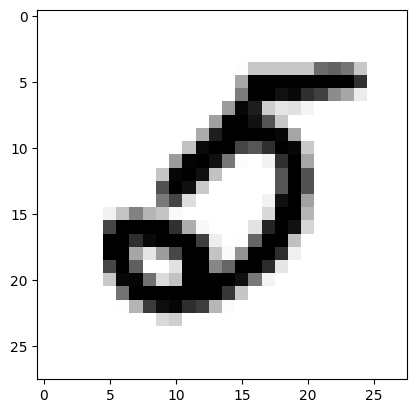

In [64]:
# We save the adversarial examples as a touple formed by initial label, predicted label, adversarial_image and epsioln
adversarial_image = matrix[0][2]

print(matrix[0][0])
print(matrix[0][2].size())
 

a = matrix[0][2].squeeze(dim=0)
b = a.squeeze(dim=0)
plt.imshow(b,  cmap='gray_r')

b.reshape(32,32)
print(b.size())

model(matrix[0][2]).argmax()
model1(b)

In [100]:
c.size()

d = c.unsqueeze(dim=0)
print(d.size())

torch.Size([1, 1, 32, 32])


In [109]:
model1.eval()

model1(d)[1].argmax()

tensor(0)

In [117]:
def transform_image(image):
  # we get a [1, 1, 28, 28] tensor and we return a [1, 1, 32, 32]
  new_image = image.squeeze(dim=0).squeeze(dim=0)
  trans = transforms.ToPILImage()
  new_image = transforms1(trans(new_image))
  new_image = new_image.unsqueeze(dim=0)
  return new_image

2
torch.Size([1, 1, 32, 32])


tensor(1)

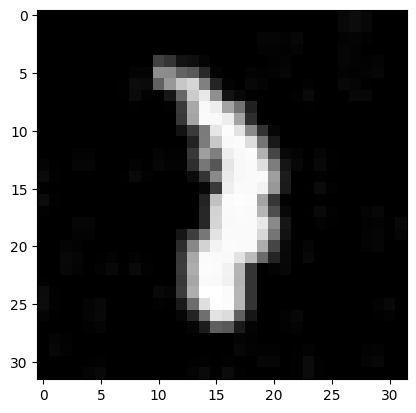

In [123]:
image = matrix[1][2]

print(matrix[1][1])
print(transform_image(image).size())

image2 = transform_image(image)

plt.imshow(image2.squeeze(dim=0).squeeze(dim=0), cmap='gray')

model1(image2)[1].argmax()